# Anthony's Beer Data Analysis
Anthony gave me his Untappd data (Untappd is a social media beer app), and we decided to do a little investigation into Anthony's beer habits. We'll start by importing all of the data:

In [1]:
from os import path
import numpy as np
import pandas as pd
import math
from IPython.display import display

if path.exists("data/AnthonyBeer.csv"):
    beer_df = pd.read_csv("data/AnthonyBeer.csv")
    display(beer_df.head())
else:
    print("File does not exist")

/home/jcroderman/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,beer_name,brewery_name,beer_type,beer_abv,beer_ibu,comment,venue_name,venue_city,venue_state,venue_country,...,serving_type,checkin_id,bid,brewery_id,photo_url,global_rating_score,global_weighted_rating_score,tagged_friends,total_toasts,total_comments
0,Shiner Oktoberfest,Spoetzl Brewery,Märzen,5.7,18,NaN,NaN,NaN,NaN,NaN,...,NaN,45008985,6348,1179,NaN,3.45,3.45,NaN,0,0
1,ESB,Redhook Brewery,Extra Special / Strong Bitter,5.8,28,NaN,NaN,NaN,NaN,NaN,...,NaN,45009120,3245,1051,NaN,3.44,3.44,NaN,0,0
2,Ellie's Brown Ale,Avery Brewing Co.,Brown Ale - American,5.5,28,NaN,NaN,NaN,NaN,NaN,...,NaN,45009485,6206,62,NaN,3.62,3.62,NaN,0,0
3,Pumpkin Beer,O'Fallon Brewery,Pumpkin / Yam Beer,5.6,11,NaN,NaN,NaN,NaN,NaN,...,NaN,45009598,9371,924,NaN,3.64,3.64,NaN,1,0
4,Messiah Nut Brown Ale,Shmaltz Brewing Company,Brown Ale - American,5.2,0,Nice almost chocolatey taste.,NaN,NaN,NaN,NaN,...,NaN,45138709,7094,1137,NaN,3.47,3.47,NaN,0,0


## Cleaning Up the Data
First, we'll get rid of any checkins that do not have ratings, as we don't care about those:

In [2]:
beer_df = beer_df[~beer_df["rating_score"].isna()]

Now, we'll split up the `created_at` field into date and time:

In [3]:
beer_df["date"] = pd.to_datetime(beer_df["created_at"], format="%Y-%m-%d %H:%M:%S")
beer_df["time"] = beer_df["date"].apply(lambda date: date.time())
beer_df["date"] = beer_df["date"].apply(lambda date: date.date())
beer_df.drop("created_at", axis=1, inplace=True)
display(beer_df["date"].describe(datetime_is_numeric=True))

count            946
unique           419
top       2017-02-25
freq              25
Name: date, dtype: object

## Feature Engineering
Because Untappd stores the beer type data into specific subtypes of beer types, we can simplify the beer type into its supergroup for more concise results:

In [4]:
def simplify_beer_type(row):
    beer_type = row["beer_type"]
    try:
        dash_index = beer_type.index(" - ")
        return beer_type[0:dash_index]
    except:
        return beer_type

beer_df["simple_beer_type"] = beer_df.apply(simplify_beer_type, axis=1)
print("Number of beer types: " + str(beer_df["simple_beer_type"].drop_duplicates().shape[0]))
beer_df.to_csv("data/simplified_data.csv")

Number of beer types: 54


## Analysis
Now here's all the data we're working with:

In [5]:
beer_df.keys()

Index(['beer_name', 'brewery_name', 'beer_type', 'beer_abv', 'beer_ibu',
       'comment', 'venue_name', 'venue_city', 'venue_state', 'venue_country',
       'venue_lat', 'venue_lng', 'rating_score', 'checkin_url', 'beer_url',
       'brewery_url', 'brewery_country', 'brewery_city', 'brewery_state',
       'flavor_profiles', 'purchase_venue', 'serving_type', 'checkin_id',
       'bid', 'brewery_id', 'photo_url', 'global_rating_score',
       'global_weighted_rating_score', 'tagged_friends', 'total_toasts',
       'total_comments', 'date', 'time', 'simple_beer_type'],
      dtype='object')

In [6]:
print("Number of total checkins: " + str(beer_df.shape[0]))

Number of total checkins: 946


### Top 10 Specific Beer Types by Number of Checkins

In [7]:
beer_types_df = beer_df[["beer_type", "beer_name"]].groupby("beer_type").count().reset_index().rename({"beer_name": "count"}, axis=1)
beer_types_df.sort_values(by="count", ascending=False).head(10).reset_index(drop=True)

,beer_type,count
0,IPA - American,112
1,Pale Ale - American,81
2,Lager - American,49
3,Lager - American Light,42
4,Wheat Beer - American Pale Wheat,31
5,Pilsner - German,23
6,Lager - Pale,22
7,Blonde Ale,22
8,IPA - Session / India Session Ale,21
9,IPA - New England,21


### Top 10 Simplified Beer Types by Number of Checkins

In [8]:
beer_simple_types_df = beer_df[["simple_beer_type", "beer_name"]].groupby("simple_beer_type").count().reset_index().rename({"beer_name": "count"}, axis=1)
beer_simple_types_df.sort_values(by="count", ascending=False).head(10).reset_index(drop=True)

,simple_beer_type,count
0,IPA,192
1,Lager,157
2,Pale Ale,98
3,Stout,83
4,Pilsner,52
5,Wheat Beer,52
6,Brown Ale,24
7,Porter,23
8,Blonde Ale,22
9,Cream Ale,17


In [9]:
print("Number of unique beers checked in: " + str(beer_df[["beer_url"]].drop_duplicates().shape[0]))

Number of unique beers checked in: 766


### Top 10 Favorite Beer Types by Average Rating

In [10]:
beer_types_ratings_df = beer_df[["simple_beer_type", "rating_score"]].groupby("simple_beer_type").mean().reset_index().rename({"rating_score": "avg rating"}, axis=1)
beer_types_ratings_df = beer_types_ratings_df.merge(beer_simple_types_df, on="simple_beer_type")
beer_types_ratings_df = beer_types_ratings_df[beer_types_ratings_df["count"] > 3]
beer_types_ratings_df.sort_values("avg rating", ascending=False).head(10).reset_index(drop=True)

,simple_beer_type,avg rating,count
0,Porter,3.989130,23
1,Scotch Ale / Wee Heavy,3.875000,4
2,IPA,3.798177,192
3,Brown Ale,3.781250,24
4,Stout,3.686747,83
5,Extra Special / Strong Bitter,3.681818,11
6,Pale Ale,3.663265,98
7,Red Ale,3.593750,16
8,Pumpkin / Yam Beer,3.550000,10
9,Belgian Strong Golden Ale,3.550000,5


### Top 10 Least Favorite Beer Types by Average Rating

In [11]:
beer_types_ratings_df.sort_values("avg rating", ascending=True).head(10).reset_index(drop=True)

,simple_beer_type,avg rating,count
0,Shandy / Radler,1.562500,4
1,Sour,1.875000,12
2,Lager,2.221338,157
3,Fruit Beer,2.454545,11
4,Altbier,3.050000,5
5,Märzen,3.125000,8
6,Golden Ale,3.125000,12
7,Cream Ale,3.191176,17
8,Hefeweizen,3.308824,17
9,Belgian Quadrupel,3.375000,6


### Most Checked In Beers

In [12]:
beer_names_df = beer_df[["beer_name", "brewery_name", "beer_type"]].groupby(["beer_name", "brewery_name"]).count().reset_index().rename({"beer_type": "count"}, axis=1)
beer_names_df.sort_values(by="count", ascending=False).head(10).reset_index(drop=True)

,beer_name,brewery_name,count
0,Bud Light,Anheuser-Busch,8
1,Unfiltered Wheat Beer,Boulevard Brewing Co.,6
2,Stag,Pabst Brewing Company,5
3,Pale Ale,Boulevard Brewing Co.,5
4,Strawberry Blonde,Border Brewing Company,5
5,8-Bit Pale Ale,Tallgrass Brewing Company,4
6,Spooky Boy,McDonough Brewery,4
7,Guinness Draught,Guinness,4
8,Tecate,Cervecería Cuauhtémoc Moctezuma S.A. de C.V.,4
9,16-Bit Double Pale Ale (2015),Tallgrass Brewing Company,4


### Top 10 Most Alcoholic Beers Checked In

In [13]:
beer_df[["beer_name", "beer_abv", "beer_ibu", "rating_score"]].sort_values(by="beer_abv", ascending=False).head(10).reset_index(drop=True)

,beer_name,beer_abv,beer_ibu,rating_score
0,Bomb!,13.0,65,3.75
1,Belzebuth (13%),13.0,0,4.00
2,Pappy Burleson (2017),13.0,0,3.00
3,Speedway Stout,12.0,70,4.75
4,Rye-on-Rye,12.0,47,4.25
5,Prickly Pear Belgian,12.0,0,3.25
6,Rye-on-Rye X - Sazerac,11.8,29,4.00
7,Whiskey Barrel Stout,11.8,32,4.50
8,Bourbon Barrel Quad (2015),11.8,19,4.00
9,Big Bad Baptista,11.7,65,4.75


In [14]:
print("Average ABV of checked in beers: {:.2f}".format(beer_df["beer_abv"].mean()))

Average ABV of checked in beers: 5.78


In [15]:
# Set up graphing functionality

import math
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
register_matplotlib_converters()
rcParams['figure.figsize'] = 18.5, 7.5
rcParams['font.size'] = 16

### Average Ratings by Beer ABV

In [16]:
beer_abv_ratings_df = beer_df[["beer_abv", "rating_score"]]
beer_abv_ratings_df["beer_abv_bucket"] = beer_abv_ratings_df.apply(lambda row: math.floor(row["beer_abv"]), axis=1)
beer_abv_ratings_df = beer_abv_ratings_df.drop(columns=["beer_abv"], axis=1)
beer_abv_ratings_counts_df = beer_abv_ratings_df.groupby("beer_abv_bucket").count().reset_index()
beer_abv_ratings_df = beer_abv_ratings_df.groupby("beer_abv_bucket").mean().reset_index()
beer_abv_ratings_df = beer_abv_ratings_df.merge(beer_abv_ratings_counts_df, on="beer_abv_bucket").rename({"rating_score_x": "avg_rating", "rating_score_y": "counts"}, axis=1)

/home/jcroderman/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


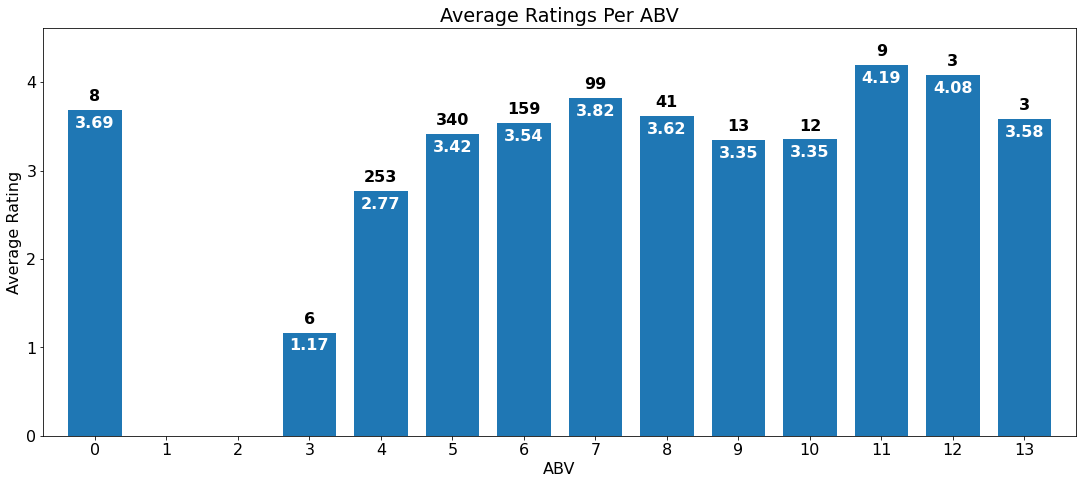

In [17]:
def show_ratings_by_abv(data):
    fig, ax = plt.subplots()
    width = 0.75 # the width of the bars 
    ax.bar(data[:,0], data[:,1], width)
    for i, count in enumerate(data[:,2]):
        ax.text(data[i,0], data[i,1] + 0.1, "{}".format(math.floor(count)), color='black', fontweight='bold', horizontalalignment='center')
    for i, hours in enumerate(data[:,1]):
        ax.text(data[i,0], data[i,1] - 0.2, "{:.2f}".format(hours), color='white', fontweight='bold', horizontalalignment='center')
    
    plt.title("Average Ratings Per ABV")
    plt.xticks(ticks=range(0, math.floor(data[len(data)-1,0]) + 1))
    plt.xlabel("ABV")
    plt.ylabel("Average Rating")
    plt.margins(0.025, 0.1)

data = beer_abv_ratings_df.to_numpy()
show_ratings_by_abv(data)

plt.show()

### Top Ten Serving Types by Average Rating of Beers

In [18]:
beer_serving_type_df = beer_df[~beer_df["serving_type"].isna()]
beer_serving_ratings_df = beer_serving_type_df[["serving_type", "rating_score"]]
beer_serving_ratings_count_df = beer_serving_ratings_df.groupby("serving_type").count().reset_index()
beer_serving_ratings_df = beer_serving_ratings_df.groupby("serving_type").mean().reset_index()
beer_serving_ratings_df = beer_serving_ratings_df.merge(beer_serving_ratings_count_df, on="serving_type").rename({"rating_score_x": "avg_rating", "rating_score_y": "counts"}, axis=1)
beer_serving_ratings_df.sort_values(by="avg_rating", ascending=False).reset_index(drop=True)

,serving_type,avg_rating,counts
0,Growler,4.083333,6
1,Crowler,3.800000,5
2,Draft,3.531707,205
3,Taster,3.505435,46
4,Nitro,3.333333,3
5,Bottle,3.262195,41
6,Can,2.932000,125


### Beers Served in Cans Rating Data

In [19]:
beer_serving_type_df[beer_serving_type_df["serving_type"] == "Can"]["rating_score"].describe()

count    125.000000
mean       2.932000
std        1.296854
min        0.250000
25%        2.000000
50%        3.500000
75%        4.000000
max        5.000000
Name: rating_score, dtype: float64

### All Beers Given a Perfect 5 Star Rating
I especially enjoy the single `Bud Light` entry

In [20]:
beer_big_rating_df = beer_df[beer_df["rating_score"] == 5.0][["beer_name", "brewery_name"]]
beer_big_rating_counts_df = beer_big_rating_df.groupby("beer_name").count()
beer_big_rating_df = beer_big_rating_df.merge(beer_big_rating_counts_df, on="beer_name").drop_duplicates()
beer_big_rating_df = beer_big_rating_df.rename({"brewery_name_x": "brewer_name", "brewery_name_y": "count"}, axis=1)
beer_big_rating_df.sort_values(by="count", ascending=False).reset_index(drop=True)

,beer_name,brewer_name,count
0,Stag,Pabst Brewing Company,3
1,Green Chili Beer,Flat Branch Pub & Brewing,2
2,Hazelnut Brown Nectar,Rogue Ales,2
3,Two Hearted Ale,Bell's Brewery,1
4,Kolsch,Franconia Brewing Company,1
5,Sweet Baby Jesus!,DuClaw Brewing Company,1
6,Imperial Stout X - Coconut,Boulevard Brewing Co.,1
7,Generation 1,Firestone Walker Brewing Company,1
8,Wedding Ale,Cold Iron Brewing,1
9,Scottish Wedding Ale,Cold Iron Brewing,1


### Top 10 Most Checked In Venues

In [21]:
venue_df = beer_df[["venue_name", "venue_city"]].groupby("venue_name").count().reset_index()
venue_df = venue_df.rename({"venue_city": "count"}, axis=1)
venue_df.sort_values(by="count", ascending=False).head(10).reset_index(drop=True)

,venue_name,count
0,HI-DIVE Lounge,63
1,International Tap House,25
2,Double Shift Brewing Company,24
3,Ruins Pub,22
4,Border Brewing Company,19
5,Under The KCTV5 Tower,19
6,Boulevard Brewing Beer Hall,16
7,Torn Label Brewing Company,14
8,Up-Down,13
9,Union Station Grand Hall,13


### Top 10 Best Venues by Average Rating

In [22]:
venue_ratings_df = beer_df[["venue_name", "rating_score"]].groupby("venue_name").mean().reset_index()
venue_ratings_df = venue_ratings_df.merge(beer_df[["venue_name", "rating_score"]].groupby("venue_name").count().reset_index(), on="venue_name")
venue_ratings_df = venue_ratings_df.rename({"rating_score_x": "avg_rating", "rating_score_y": "count"}, axis=1)
venue_ratings_df = venue_ratings_df[venue_ratings_df["count"] > 5]
venue_ratings_df.sort_values(by="avg_rating", ascending=False).head(10).reset_index(drop=True)

,venue_name,avg_rating,count
0,Elizabeth Warren Campaign Office,3.875000,6
1,Double Shift Brewing Company,3.802083,24
2,Torn Label Brewing Company,3.785714,14
3,Grinders,3.777778,9
4,Border Brewing Company,3.671053,19
5,Under The KCTV5 Tower,3.671053,19
6,The Ginger Man,3.666667,6
7,City Barrel Brewing Company,3.625000,6
8,Boulevard Brewing Beer Hall,3.625000,16
9,Cold Iron,3.611111,9


### Flavor Profiles Info
I never actually did anything with this

In [23]:
beer_flavor_profiles_df = beer_df[~beer_df["flavor_profiles"].isna()]
longest_profile_list = 0
for flavor_profiles_list in beer_flavor_profiles_df.apply(lambda row: row["flavor_profiles"].split(","), axis=1).to_numpy():
    if len(flavor_profiles_list) > longest_profile_list:
        longest_profile_list = len(flavor_profiles_list)
print("Most flavor profiles listed on one checkin" + str(longest_profile_list))

Most flavor profiles listed on one checkin5


In [24]:
# Split up flavor profiles in separate columns
beer_flavor_profiles_df[["flavor_profiles_1", "flavor_profiles_2", "flavor_profiles_3", "flavor_profiles_4", "flavor_profiles_5"]] = beer_flavor_profiles_df.apply(lambda row: pd.Series(row["flavor_profiles"].split(",")), axis=1)
beer_flavor_profiles_df[["beer_name", "flavor_profiles", "flavor_profiles_1", "flavor_profiles_2", "flavor_profiles_3", "flavor_profiles_4", "flavor_profiles_5", "rating_score"]].head()

/home/jcroderman/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,beer_name,flavor_profiles,flavor_profiles_1,flavor_profiles_2,flavor_profiles_3,flavor_profiles_4,flavor_profiles_5,rating_score
370,Chocolate Double Stout,"sweet,dark",sweet,dark,NaN,NaN,NaN,2.50
374,Carpe Brewem Imperial Mango IPA,"citrusy,subtle,fruity,hoppy",citrusy,subtle,fruity,hoppy,NaN,3.25
375,Milkshake IPA,"milk,smooth",milk,smooth,NaN,NaN,NaN,4.00
381,Mint Chocolate Milk Stout,"minty,thin",minty,thin,NaN,NaN,NaN,4.50
391,Stag,"light,warm",light,warm,NaN,NaN,NaN,5.00


### Weekday Infomation

In [25]:
# Set up weekday feature
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
beer_df["weekday"] = beer_df.apply(lambda row: row["date"].weekday(), axis=1)
beer_df[["date", "weekday"]].tail()

,date,weekday
951,2020-11-26,3
952,2020-12-04,4
953,2020-12-04,4
954,2020-12-11,4
955,2020-12-12,5


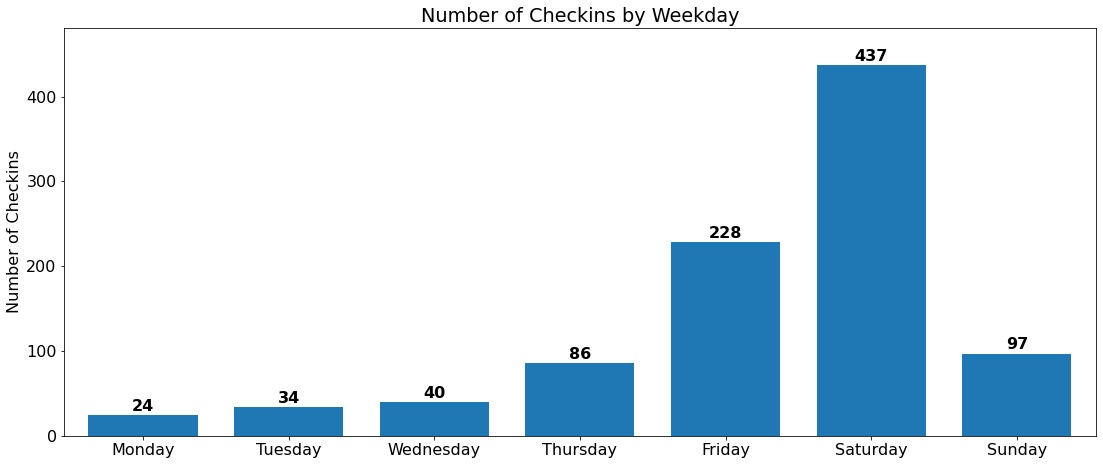

In [26]:
def show_counts_by_weekday(data):
    fig, ax = plt.subplots()
    width = 0.75 # the width of the bars 
    ax.bar(data[:,0], data[:,1], width)
    for i, count in enumerate(data[:,1]):
        ax.text(i, data[i,1] + 5, "{}".format(math.floor(count)), color='black', fontweight='bold', horizontalalignment='center')
    
    plt.title("Number of Checkins by Weekday")
    plt.xticks(ticks=range(len(data)), labels=weekdays)
    plt.ylabel("Number of Checkins")
    plt.margins(0.025, 0.1)


beer_weekday_df = beer_df[["weekday", "beer_name"]].groupby("weekday").count().reset_index()
beer_weekday_df = beer_weekday_df.rename({"beer_name": "count"}, axis=1)
data = beer_weekday_df.to_numpy()
show_counts_by_weekday(data)

plt.show()

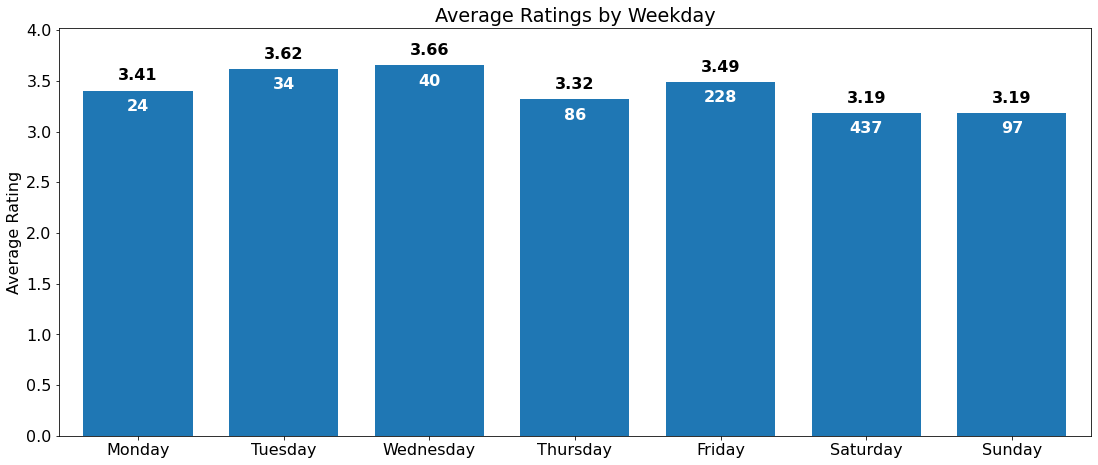

In [27]:
def show_avg_rating_by_weekday(data):
    fig, ax = plt.subplots()
    width = 0.75 # the width of the bars 
    ax.bar(data[:,0], data[:,2], width)
    for i, rating in enumerate(data[:,2]):
        ax.text(i, data[i,2] + 0.1, "{:.2f}".format(rating), color='black', fontweight='bold', horizontalalignment='center')
    for i, count in enumerate(data[:,1]):
        ax.text(i, data[i,2] - 0.2, "{}".format(math.floor(count)), color='white', fontweight='bold', horizontalalignment='center')
    
    plt.title("Average Ratings by Weekday")
    plt.xticks(ticks=range(len(data)), labels=weekdays)
    plt.ylabel("Average Rating")
    plt.margins(0.025, 0.1)

beer_weekday_ratings_df = beer_df[["weekday", "rating_score"]].groupby("weekday").mean().reset_index()
data = beer_weekday_df.merge(beer_weekday_ratings_df, on="weekday").rename({"rating_score": "avg_rating"}, axis=1)
data = data.to_numpy()
show_avg_rating_by_weekday(data)

plt.show()

### Top 10 Most Frequented Venues by Date
Note: Could be off checking in to same venue before and after midnight

In [28]:
venue_df = beer_df[["venue_name", "date"]].drop_duplicates().groupby("venue_name").count().reset_index()
venue_df = venue_df.rename({"date": "count"}, axis=1)
venue_df = venue_df.sort_values(by="count", ascending=False).head(10).reset_index(drop=True)
venue_df

,venue_name,count
0,HI-DIVE Lounge,37
1,Untappd at Home,19
2,Under The KCTV5 Tower,17
3,Double Shift Brewing Company,13
4,International Tap House,12
5,Border Brewing Company,10
6,Ruins Pub,10
7,Grinders,8
8,Casual Animal Brewing Company,8
9,Up-Down,7


In [29]:
print("Top Venue: " + venue_df.iloc[0]["venue_name"])
top_venue_date_data = beer_df[beer_df["venue_name"] == venue_df.iloc[0]["venue_name"]][["venue_name", "date"]].drop_duplicates()["date"]
print("First time visiting: " + top_venue_date_data.min().strftime("%D"))
print("Last time visiting (since {}): {}".format(beer_df.iloc[-1]["date"].strftime("%D"), top_venue_date_data.max().strftime("%D")))

Top Venue: HI-DIVE Lounge
First time visiting: 11/05/16
Last time visiting (since 12/12/20): 02/16/20


### Beer Types Over Months

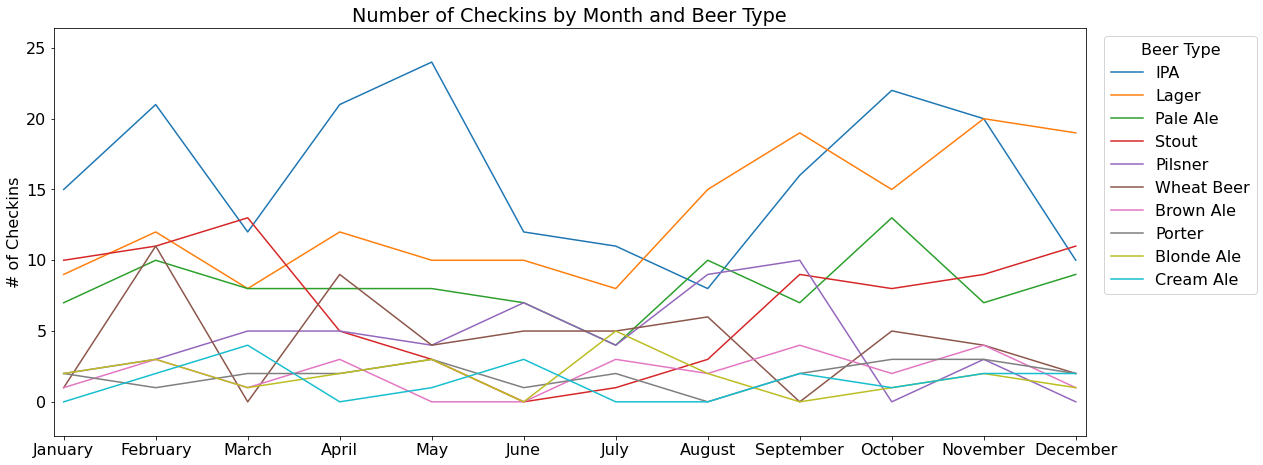

In [30]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

def show_beer_type_by_month(data):
    fig, ax = plt.subplots()
    
    beer_types = data[["simple_beer_type", "count"]].groupby("simple_beer_type").sum().reset_index().sort_values(by="count", ascending=False)["simple_beer_type"]
    for beer_type in beer_types:
        beer_type_data = data[data["simple_beer_type"] == beer_type].drop(columns=["simple_beer_type"], axis=1)
        for i in range(1, 13):
            if beer_type_data[beer_type_data["month"] == i].shape[0] == 0:
                beer_type_data = beer_type_data.append({"month": i, "count": 0}, ignore_index=True)
        beer_type_data = beer_type_data.sort_values(by="month", ascending=True).to_numpy()
        ax.plot(beer_type_data[:,0], beer_type_data[:,1], label=beer_type)

    plt.title("Number of Checkins by Month and Beer Type")
    plt.xticks(ticks=range(1,13), labels=months)
    plt.ylabel("# of Checkins")
    plt.legend(title='Beer Type', bbox_to_anchor=(1.01, 1))
    plt.margins(0.01, 0.1)

data = beer_df[["simple_beer_type", "date"]]
top_beers = beer_simple_types_df.sort_values(by="count", ascending=False).head(10)["simple_beer_type"].to_numpy()
data = data[data["simple_beer_type"].isin(top_beers)]
# data["year"] = data.apply(lambda row: pd.to_datetime(row["date"]).year, axis=1)
data["month"] = data.apply(lambda row: pd.to_datetime(row["date"]).month, axis=1)
# data = data[data["year"] == 2020]
data = data.groupby(["month", "simple_beer_type"]).count().reset_index().rename({"date": "count"}, axis=1)
show_beer_type_by_month(data)

plt.show()

/home/jcroderman/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


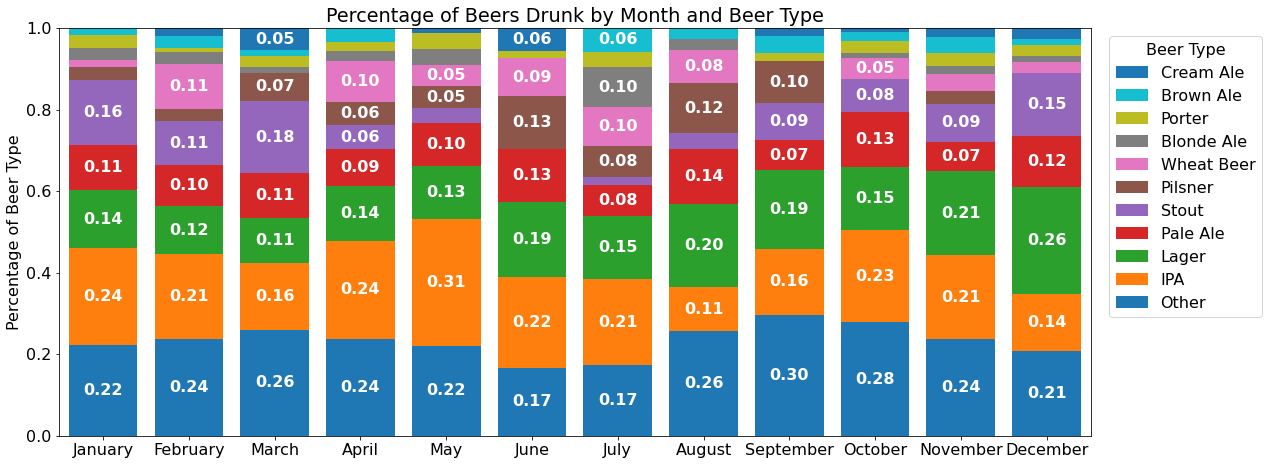

In [31]:
def show_percentage_beer_type_by_month(data):
    fig, ax = plt.subplots()
    
    bottom = 12 * [0]
    beer_types = data[["simple_beer_type", "percentage"]].groupby("simple_beer_type").sum().reset_index().sort_values(by="percentage", ascending=False)["simple_beer_type"]
    for beer_type in beer_types:
        beer_type_data = data[data["simple_beer_type"] == beer_type].drop(columns=["simple_beer_type"], axis=1)
        for i in range(1, 13):
            if beer_type_data[beer_type_data["month"] == i].shape[0] == 0:
                beer_type_data = beer_type_data.append({"month": i, "percentage": 0}, ignore_index=True)
        beer_type_data = beer_type_data.sort_values(by="month", ascending=True).to_numpy()
        for i, percentage in enumerate(beer_type_data[:,1]):
            if percentage >= 0.05:
                ax.text(i + 1, bottom[i] + (beer_type_data[i,1] / 2), "{:.2f}".format(percentage), color='white', fontweight='bold', horizontalalignment='center', verticalalignment='center')
        ax.bar(beer_type_data[:,0], beer_type_data[:,1], label=beer_type, bottom=bottom)
        bottom = bottom + beer_type_data[:,1]

    plt.title("Percentage of Beers Drunk by Month and Beer Type")
    plt.xticks(ticks=range(1,13), labels=months)
    plt.ylabel("Percentage of Beer Type")
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], title='Beer Type', bbox_to_anchor=(1.01, 1))
    plt.margins(0.01, 0.1)

data = beer_df[["simple_beer_type", "date"]]
top_beers = beer_simple_types_df.sort_values(by="count", ascending=False).head(10)["simple_beer_type"].to_numpy()
data["month"] = data.apply(lambda row: pd.to_datetime(row["date"]).month, axis=1)
data = data.groupby(["month", "simple_beer_type"]).count().reset_index().rename({"date": "count"}, axis=1)

def calc_percentages(month_data):
    total = month_data["count"].sum()
    month_data["percentage"] = month_data.apply(lambda row: row["count"] / total, axis=1)
    return month_data

data = data.groupby("month").apply(calc_percentages).drop(columns=["count"])
leftover_data = data[~data["simple_beer_type"].isin(top_beers)]
data = data[data["simple_beer_type"].isin(top_beers)]
for i, percentage in enumerate(leftover_data.groupby("month").sum().to_numpy()):
    data = data.append({"month": i + 1, "simple_beer_type": "Other", "percentage": percentage[0]}, ignore_index=True)

show_percentage_beer_type_by_month(data)

plt.show()

I think the most interesting thing about this chart is that Anthony drinks way less `Stouts` in the summer months and more of them in the winter months, and drinks more `Pilsners` in the summer months and less of them in the winter months

### Toasts Data
Toasts are Untappd's equivalent of `likes`. If another user likes your post, they can `toast` it

In [32]:
print("Average number of toasts per post: {:.2f}".format(beer_df["total_toasts"].mean()))
print("Max number of toasts per post: " + str(beer_df["total_toasts"].max()))

Average number of toasts per post: 0.48
Max number of toasts per post: 5


### Top 10 Most Toasted Beer Posts

In [33]:
beer_df[["total_toasts", "beer_name", "brewery_name", "beer_type", "beer_abv", "venue_name", "rating_score", "global_rating_score", "date", "comment"]].sort_values(by="total_toasts", ascending=False).head(10).reset_index(drop=True)

,total_toasts,beer_name,brewery_name,beer_type,beer_abv,venue_name,rating_score,global_rating_score,date,comment
0,5,420 Extra Pale Ale,SweetWater Brewing Company,Pale Ale - American,5.7,Tower Tavern,4.25,3.61,2019-08-10,NaN
1,4,Jam Band,Boulevard Brewing Co.,Fruit Beer,5.9,Untappd at Home,2.25,3.55,2020-04-17,NaN
2,3,Lucky Ducky Irish Ale,Anthem Brewing Company,Red Ale - Irish,4.0,The Bleu Garten,3.00,3.49,2018-03-17,NaN
3,3,Lemon Shandy,Shock Top Brewing Co.,Shandy / Radler,4.2,HI-DIVE Lounge,0.25,3.25,2018-07-21,I would rathef
4,3,Víking Sumaröl,Viking Brewery,Wheat Beer - Witbier,5.0,Vatnajökull National Park (Vatnajökulsþjóðgarður),2.50,3.25,2019-08-03,NaN
5,3,Happiness,City Barrel Brewing Company,Farmhouse Ale - Saison,5.7,City Barrel Brewing Company,3.75,3.74,2019-08-17,Wow! Fruity! 🍍
6,3,Coffee Stout,Rochester Brewing And Roasting Company,Stout - Coffee,8.1,Rochester Brewing and Roasting Company,4.00,4.00,2019-09-07,NaN
7,3,801 Small Batch Pilsner,Uinta Brewing Company,Pilsner - Other,5.0,Thai Garden Bistro,3.75,3.42,2019-06-30,NaN
8,3,Pappy Burleson (2017),Anthem Brewing Company,Wheat Beer - Wheat Wine,13.0,Poppy's Cafe,3.00,4.01,2018-05-12,NaN
9,3,Summer Shandy,Jacob Leinenkugel Brewing Company,Shandy / Radler,4.2,Leinenkugel's Kansas City,1.00,3.51,2016-04-07,I tried. But no.


### Top 10 Most Used Words in Comments

In [34]:
import re

beer_comments = beer_df[~beer_df["comment"].isna()]["comment"]
all_beer_comment_words = list(filter(lambda word: len(word) > 3, re.sub(r"[^a-zA-Z0-9 ]", "", " ".join(beer_comments)).lower().split(" ")))

word_frequency = {}
for word in all_beer_comment_words:
    if word in word_frequency:
        word_frequency[word] += 1
    else:
        word_frequency[word] = 1
word_frequency = dict(sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)[:10])
word_frequency

{'beer': 22,
 'like': 15,
 'this': 12,
 'tastes': 12,
 'good': 8,
 'better': 6,
 'light': 5,
 'pretty': 5,
 'about': 3,
 'with': 3}

# Conclusion
What have we learned? Anthony likes beer.